# Initialize Simulation

In [1]:
from myAgent import CarlaAgent
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
import os
import sys
import cv2

try:
    sys.path.append(glob.glob('carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla

In [2]:
myAgent = CarlaAgent()
# myAgent.world = myAgent.client.load_world("Town04")

Establishing Connection to Server


In [3]:
spawn_location = carla.Transform(carla.Location(x=68.331055, y=13.360283, z=11.057558), carla.Rotation(pitch=0.178746, yaw=-179.767502, roll=-0.007507))
checkpoint1 = carla.Transform(carla.Location(x=-505.901550, y=118.165741, z=0.001829), carla.Rotation(pitch=-0.008941, yaw=90.287453, roll=0.000932))
checkpoint2 = carla.Transform(carla.Location(x=76.616714, y=-347.043304, z=0.001787), carla.Rotation(pitch=-0.006591, yaw=-36.155972, roll=0.002479))
checkpoint3 = carla.Transform(carla.Location(x=330.723480, y=16.509901, z=0.644050), carla.Rotation(pitch=1.374207, yaw=-177.314911, roll=0.044957))
checkpoint4 = carla.Transform(carla.Location(x=-247.346359, y=12.585312, z=2.412686), carla.Rotation(pitch=-2.391632, yaw=179.684631, roll=0.019005))


myAgent.spawn_vehicle(transform=spawn_location)
myAgent.find_vehicle()

myAgent.attach_camera()
myAgent.attach_cameraS()
myAgent.attach_GNSS()

myAgent.attach_controller()

print("deployed")

created vehicle.tesla.model3
created sensor.camera.rgb
created sensor.camera.semantic_segmentation
created sensor.other.gnss
deployed


In [25]:
myAgent.terminate()

destroying actors
terminated


# Navigation

### GNSS Geolocation data on Autopilot

In [33]:
sim_time = 30

x = [myAgent.longitude]
y = [myAgent.latitude]
z = [myAgent.altitude]

print("Demo navigation test")

myAgent.control.throttle = 0
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 0
myAgent.control.reverse = 0

myAgent.vehicle.apply_control(myAgent.control)

myAgent.vehicle.set_autopilot(True)

t = time.time()
while(time.time()-t < sim_time):
    
    x.append(myAgent.longitude)
    y.append(myAgent.latitude)
    z.append(myAgent.altitude)

myAgent.vehicle.set_autopilot(False)

myAgent.control.throttle = 0
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 1
myAgent.control.reverse = 0
myAgent.vehicle.apply_control(myAgent.control)

myAgent.find_vehicle()

x = np.array(x)
y = np.array(y)

# plt.plot(x, y)
# plt.show()

print("done")

Demo navigation test
done


### Random Geolocation

GeoLocation(latitude=0.001622, longitude=0.001178, altitude=0.400000)


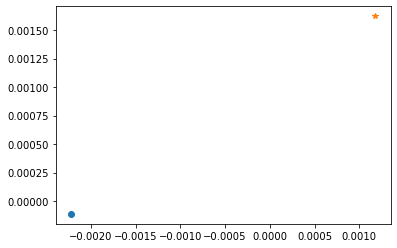

Transform(Location(x=-247.346359, y=12.585312, z=2.412686), Rotation(pitch=-2.391632, yaw=179.684631, roll=0.019005))


In [12]:
transform = random.choice(myAgent.map.get_spawn_points())
goal = myAgent.map.transform_to_geolocation(transform.location)

print(goal)

plt.plot(myAgent.longitude, myAgent.latitude, 'o')
plt.plot(goal.longitude, goal.latitude, '*')
plt.show()

print(myAgent.vehicle.get_transform())

In [4]:
myAgent.terminate()

destroying actors
terminated


# Navigation with GNSS waypoint and GT Segmentation

In [4]:
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    return labeled_img

def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255

    return img2

def get_centroid(image):
    
    moment = cv2.moments(image)

    # calculate x,y coordinate of center
    try:
        cX = int(moment["m10"] / moment["m00"])
        cY = int(moment["m01"] / moment["m00"])
    except:
        cX = int(IMAGE_W/2)
        cY = int(IMAGE_H/2)
    
    return cX, cY


In [5]:
sim_time = 300
autopilot = False


IMAGE_H, IMAGE_W, _ = myAgent.image.shape
src = np.float32([[0, IMAGE_H], [IMAGE_W, IMAGE_H],
                  [int(3*IMAGE_W/7), int(IMAGE_H/2)], [int(4*IMAGE_W/7), int(IMAGE_H/2)]])
dst = np.float32([[300, IMAGE_H], [500, IMAGE_H], [300, 0], [500, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix   

kernel = np.ones((5,5),np.uint8)


myAgent.control.throttle = 0
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 0
myAgent.control.reverse = 0

myAgent.vehicle.apply_control(myAgent.control)

myAgent.vehicle.set_autopilot(autopilot)

t = time.time()
lap = t
while(time.time()-t < sim_time):

    if (time.time() - lap > 3):
        lap = time.time()
        myAgent.find_vehicle()
        
    road_class = 7
    RGB = myAgent.image
    sem = np.copy(myAgent.imageS[:,:,2])
    sem[sem!=road_class] = 0
    sem[sem==road_class] = 255

    warped_RGB = cv2.warpPerspective(RGB, M, (IMAGE_W, IMAGE_H)) # Image warping
    warped_sem = cv2.warpPerspective(sem, M, (IMAGE_W, IMAGE_H)) # Image warping

    # warped_sem = cv2.morphologyEx(warped_sem, cv2.MORPH_CLOSE, kernel)
    # warped_sem = cv2.morphologyEx(warped_sem, cv2.MORPH_OPEN, kernel)

    warped_sem = undesired_objects(warped_sem)
    
    y1, y2 = int(3*IMAGE_W/7), int(4*IMAGE_W/7)
    x1 = int(IMAGE_H/4)

    mask_f = np.zeros_like(sem)
    mask_l = np.zeros_like(sem)
    mask_r = np.zeros_like(sem)
    
    mask_f[:, y1:y2] = 1
    mask_l[x1:, :y2] = 1
    mask_r[x1:, y1:] = 1

    path_f = np.multiply(warped_sem, mask_f)
    path_l = np.multiply(warped_sem, mask_l)
    path_r = np.multiply(warped_sem, mask_r)
    
    (cX_f, cY_f) = get_centroid(path_f)
    (cX_l, cY_l) = get_centroid(path_l)
    (cX_r, cY_r) = get_centroid(path_r)
      
    # put text and highlight the center
    cv2.circle(warped_RGB, (cX_f, cY_f), 20, (0, 0, 255), -1)
    cv2.circle(warped_RGB, (cX_l, cY_l), 20, (0, 0, 255), -1)
    cv2.circle(warped_RGB, (cX_r, cY_r), 20, (0, 0, 255), -1)    

    if autopilot == False:
        
        myAgent.control.throttle = (cY_f + cY_l + cY_r)/(3*IMAGE_H) - 0.2*((IMAGE_W/2-cX_l)/(IMAGE_W))/(cY_f/IMAGE_H) - 0.2*((cX_r-IMAGE_W/2)/(IMAGE_W))/(cY_f/IMAGE_H) 
        
        myAgent.control.steer = (4*(cX_f-IMAGE_W/2)/(IMAGE_W))*(cY_f/IMAGE_H) + 0.2*((cX_l-IMAGE_W/2)/(IMAGE_W))/(cY_f/IMAGE_H) + 0.2*((cX_r-IMAGE_W/2)/(IMAGE_W))/(cY_f/IMAGE_H) 
        
        myAgent.vehicle.apply_control(myAgent.control)
    
    

    sem_3 = cv2.cvtColor(sem, cv2.COLOR_GRAY2BGR)
    # warped_sem = cv2.cvtColor(warped_sem, cv2.COLOR_GRAY2BGR)


    # plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    # plt.imshow(cv2.cvtColor(stack3, cv2.COLOR_BGR2RGB)) # Show results
    # plt.show()

    cv2.imshow('camera feed', RGB)
    cv2.imshow('warped RGB', warped_RGB)
    cv2.imshow('Roadmap', warped_sem)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cv2.destroyAllWindows()
        
myAgent.vehicle.set_autopilot(False)

myAgent.control.throttle = 0
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 1
myAgent.control.reverse = 0
myAgent.vehicle.apply_control(myAgent.control)

myAgent.find_vehicle()


In [11]:
cv2.destroyAllWindows()

### Reverse Gear

In [9]:
myAgent.control.throttle = 0.5
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 0
myAgent.control.reverse = 1

myAgent.vehicle.apply_control(myAgent.control)


t = time.time()
while(time.time()-t < 5):
    None
    
myAgent.control.throttle = 0
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 1
myAgent.control.reverse = 0

myAgent.vehicle.apply_control(myAgent.control)

# Terminate Simulation

In [6]:
myAgent.terminate()

destroying actors
terminated
